In [1]:
import numpy as np
import pandas as pd
from surprise import SVD
from surprise import Dataset, Reader 
from surprise.model_selection import train_test_split
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, KNNWithMeans
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms.baseline_only import BaselineOnly
import numpy as np
from scipy.sparse.linalg import svds
from sklearn import model_selection
from scipy.sparse import csr_matrix
from IPython.display import display

In [2]:
ratings = pd.read_csv('final_final_ratings.csv', 
                      names=['userId', 'productId', 'rating'], 
                      skiprows=1)

# Convert the 'rating' column back to float
ratings['rating'] = ratings['rating'].astype(float)

# Save an original copy of the dataframe
ratings_original = ratings.copy(deep=True)

In [3]:
ratings

,userId,productId,rating
0,A4WEZJOIZIV4U,B0771RT4PM,5.0
1,A3BKNXX8QFIXIV,B0771RT4PM,5.0
2,ASB4QQBKZD6W2,B0771RT4PM,3.0
3,A3QRW0UJPKIAX7,B0771RT4PM,5.0
4,AIBRTGBN07D6A,B0771RT4PM,4.0
...,...,...,...
22691,AVFIQ58VHSFZH,B0BHPT8L26,5.0
22692,AOVMTR7PA8XB9,B0BZY41481,5.0
22693,ABUWUTWYZ8V1R,B0B5B77WTY,4.0
22694,A2V026TK7H80V3,B09BZLKRHC,3.0


## Finding the number of distinct values for each column

In [4]:
distinct_userIds = ratings['userId'].nunique()
print("Distinct User IDs:", distinct_userIds)

distinct_productIds = ratings['productId'].nunique()
print("Distinct Product IDs:", distinct_productIds)

distinct_ratings = ratings['rating'].nunique()
print("Distinct Ratings:", distinct_ratings)

Distinct User IDs: 2209
Distinct Product IDs: 6282
Distinct Ratings: 5


## Splitting the data into train and dataset with ratio 70:30

In [5]:
# Divide the dataset in 70:30 ratio
trainset, testset = model_selection.train_test_split(ratings, test_size=0.3, random_state=5)

In [6]:
testset.head()

,userId,productId,rating
11372,A1CST2WUA32GP0,B0BWSH8J3W,3.0
12721,A2UOHALGF2X77Q,B07MWCNR3W,4.0
15750,ALNE7Q71JFC0F,B098V2CFFS,4.0
3575,A7WF9BHWSCRGW,B09C1356VM,5.0
18680,A2XJMQ2COPGWJH,B0BY937F79,4.0


In [7]:
trainset.head()

,userId,productId,rating
22580,A3VCZYKQIIZPSY,B09C4WM8VB,5.0
6491,A2FG061KDA1ARB,B0CMZ9J7GZ,5.0
8325,AUYAZMEO659OX,B0BVT98NBZ,5.0
10132,A2CZDT27T36DBB,B09BDNFDNN,5.0
20649,A1VVRA3P6G1TWH,B01IEZ9VP2,5.0


In [8]:
print('Shape of the training set  :', trainset.shape)
print('Shape of the test set      :', testset.shape)



Shape of the training set  : (15887, 3)
Shape of the test set      : (6809, 3)


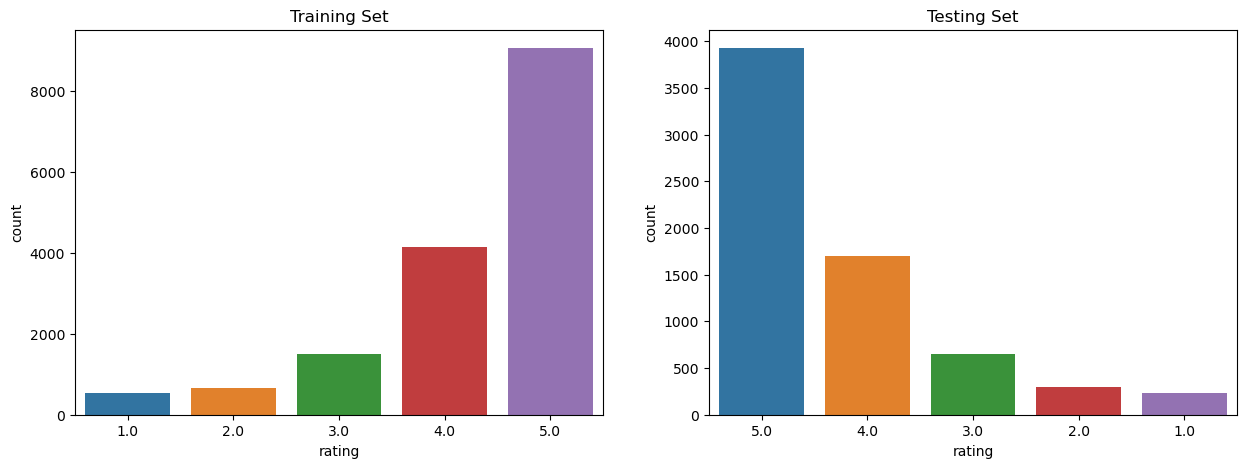

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title('Training Set')
sns.countplot(x='rating', data=trainset, ax=axes[0])
axes[1].set_title('Testing Set')
sns.countplot(x='rating', data=testset, ax=axes[1], order=testset['rating'].value_counts().index)

plt.show()

In [10]:
# Method to Recommend the items with the highest predicted ratings
def recommend_items(userId, orig_df, preds_df, top_n):
    # Get and sort the user's ratings
    sorted_user_ratings = orig_df.loc[userId].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[userId].sort_values(ascending=False)

    # Prepare recommendations
    recommendations = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    recommendations.index.name = 'Recommended Items'
    recommendations.columns = ['User Ratings', 'Predicted Ratings']

    # Take the products which the user has NOT rated
    recommendations = recommendations.loc[recommendations['User Ratings'] == 0]
    recommendations = recommendations.sort_values('Predicted Ratings', ascending=False)
    return recommendations.head(top_n)

## [Matrix factorization Collaborative Filtering](https://medium.com/sfu-cspmp/recommendation-systems-collaborative-filtering-using-matrix-factorization-simplified-2118f4ef2cd3)




In [11]:
# Create the User-Item sparse matrix
user_item = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of User-Item sparse matrix:', user_item.shape)
user_item.head()

Shape of User-Item sparse matrix: (2209, 6282)


productId,B000UXZQ42,B0016MNBAM,B001IDZG0W,B001QSZ8BG,B001SH6N8W,B002J23III,B002RAQND4,B0033B4310,B0035ERKYW,B003D8ZT0C,...,B0CN6ZHVTG,B0CN73HNV5,B0CN74CH58,B0CN78DYC2,B0CN7C8TLD,B0CNNQ2HGH,B0CNQ5FZ6Z,B0CNS35XVZ,B0CNS6F39B,B0CP4FL3HQ
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A109XLG7SJQAIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Convert the dense DataFrame to a sparse matrix
user_item_sparse = csr_matrix(user_item.values)

# Trying out different latent factors
svd_list = [svds(user_item_sparse, k=k) for k in [100, 250, 500, 750, 1000]]
pred_list = [pd.DataFrame(np.dot(np.dot(svd[0], np.diag(svd[1])), svd[2]), 
                          index=user_item.index, 
                          columns=user_item.columns) for svd in svd_list]
RMSE_list = [round((((user_item - pred) ** 2).mean().mean()) ** 0.5, 5) for pred in pred_list]
RMSE_list

[0.15904, 0.14067, 0.11739, 0.09814, 0.08089]

In [13]:
# Singular Value Decomposition
U, sigma, Vt = svds(user_item_sparse, k=50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [14]:
# Predicted ratings
svd_prediction = pd.DataFrame(np.dot(np.dot(U, sigma), Vt), index=user_item.index, columns=user_item.columns)
svd_prediction.head()

productId,B000UXZQ42,B0016MNBAM,B001IDZG0W,B001QSZ8BG,B001SH6N8W,B002J23III,B002RAQND4,B0033B4310,B0035ERKYW,B003D8ZT0C,...,B0CN6ZHVTG,B0CN73HNV5,B0CN74CH58,B0CN78DYC2,B0CN7C8TLD,B0CNNQ2HGH,B0CNQ5FZ6Z,B0CNS35XVZ,B0CNS6F39B,B0CP4FL3HQ
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,-0.008492,0.055190,0.024104,-0.009860,0.213740,-0.011347,0.012488,0.119094,0.047305,-0.001819,...,0.052585,0.316346,0.236170,0.485081,-0.165311,-0.130732,1.023051,0.015146,3.439208,-0.266378
A100WO06OQR8BQ,-0.001295,-0.002143,0.004691,0.001173,-0.025466,0.002000,0.001331,-0.005371,0.000512,0.008145,...,-0.000058,0.024615,0.003739,0.017037,-0.045781,-0.163883,-0.019292,0.095241,0.212157,-0.015458
A105S56ODHGJEK,-0.003842,-0.001494,0.041923,-0.002542,0.081669,-0.006905,-0.004012,-0.043912,0.004589,0.001054,...,0.020553,-0.103880,0.089677,0.140642,-0.073735,-0.116424,-0.187280,0.347395,0.290715,0.318516
A105TOJ6LTVMBG,-0.001471,0.008554,0.002035,0.000616,-0.036192,-0.001177,0.007591,-0.028878,-0.001399,0.003996,...,0.032680,0.105825,0.078112,0.036384,-0.014461,0.127429,-0.046304,-0.088028,0.114536,-0.054977
A109XLG7SJQAIA,0.000128,0.009786,0.000627,0.001104,0.008318,-0.002382,0.000333,0.011380,0.005245,-0.003897,...,0.001723,-0.007827,-0.008573,0.001754,-0.005867,-0.023437,-0.012609,0.014678,-0.072041,0.006811


In [15]:
# Find recommendation for a couple of users
find_recom = {'A100UD67AHFODS': 6, 
              'A100WO06OQR8BQ': 3, 
              'A105S56ODHGJEK': 8}   # This list is user, top_n recommendation dict.

for user in find_recom:
    print(f"Top {find_recom[user]} recommendations for the userId: {user}")
    display(recommend_items(user, user_item, svd_prediction, find_recom[user]))
    print("\n")

Top 6 recommendations for the userId: A100UD67AHFODS


,User Ratings,Predicted Ratings
Recommended Items,,
B0C1ZRDGM2,0.0,1.539671
B0CNQ5FZ6Z,0.0,1.023051
B07T9KJMCG,0.0,0.908277
B07FPBC2G2,0.0,0.876912
B0CJVY1Y2P,0.0,0.843514
B0C5HP6L1H,0.0,0.821405




Top 3 recommendations for the userId: A100WO06OQR8BQ


,User Ratings,Predicted Ratings
Recommended Items,,
B0CCSFKCJ4,0.0,0.589005
B0BQJMRXQV,0.0,0.482416
B08L5S4CRB,0.0,0.380932




Top 8 recommendations for the userId: A105S56ODHGJEK


,User Ratings,Predicted Ratings
Recommended Items,,
B0BWQPV33L,0.0,0.592154
B0C7QCHGLF,0.0,0.575670
B0CBCVXBV5,0.0,0.506977
B0BXPGCZSJ,0.0,0.467494
B0BYZRL5S9,0.0,0.459939
B0C1ZRDGM2,0.0,0.381067
B0CHDT157Z,0.0,0.373173
B0CJVX4RP8,0.0,0.371359


## Evaluation of The Model

In [16]:
# Method to calculate RMSE for different model
def calculate_rmse(orig_df, preds_df):
    rmse_df = pd.concat([orig_df.mean(), preds_df.mean()], axis=1)
    rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
    RMSE = round(np.sqrt(((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean()), 5)
    print('\nRMSE for this recommender model = {}\n'.format(RMSE))
    return rmse_df.head()

In [17]:
calculate_rmse(user_item, svd_prediction)


RMSE for this recommender model = 0.00317



,Avg_actual_ratings,Avg_predicted_ratings
productId,,
B000UXZQ42,0.004527,0.000650
B0016MNBAM,0.006338,0.003593
B001IDZG0W,0.002263,0.003582
B001QSZ8BG,0.003622,0.001531
B001SH6N8W,0.012675,0.010976


## Get top K-products

In [18]:
# Create a list of users
users = ['A100UD67AHFODS','A100WO06OQR8BQ']
top_k = 5

In [19]:
print('Matrix Factorization based Collaborative Filtering (SVD)')
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    display(recommend_items(user, user_item, svd_prediction, top_k))
    print("\n")

Matrix Factorization based Collaborative Filtering (SVD)
Top 5 recommendations for the userId: A100UD67AHFODS


,User Ratings,Predicted Ratings
Recommended Items,,
B0C1ZRDGM2,0.0,1.539671
B0CNQ5FZ6Z,0.0,1.023051
B07T9KJMCG,0.0,0.908277
B07FPBC2G2,0.0,0.876912
B0CJVY1Y2P,0.0,0.843514




Top 5 recommendations for the userId: A100WO06OQR8BQ


,User Ratings,Predicted Ratings
Recommended Items,,
B0CCSFKCJ4,0.0,0.589005
B0BQJMRXQV,0.0,0.482416
B08L5S4CRB,0.0,0.380932
B09V19NG1T,0.0,0.354678
B09C1356VM,0.0,0.352897
